<a href="https://colab.research.google.com/github/kuds/rl-atari-pong/blob/main/%5BAtari%20Pong%5D%20Single-Agent%20Reinforcement%20Learning%20DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Atari Tennis] Single-Agent Reinforcement Learning DQN

In [1]:
!pip install swig

In [2]:
!pip install gymnasium gymnasium[atari] autorom

In [3]:
!AutoROM --accept-license

AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.10/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.


In [4]:
!pip install stable-baselines3

In [5]:
import os
import csv
import time
import json
import platform
import torch
import numpy
import stable_baselines3
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import CallbackList
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.vec_env import VecVideoRecorder
from stable_baselines3.common.vec_env import VecTransposeImage
import matplotlib.pyplot
import matplotlib
import gymnasium
from importlib.metadata import version
from datetime import datetime
import google.colab.drive

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


In [6]:
print(f"Python Version: {platform.python_version()}")
print(f"Torch Version: {version('torch')}")
print(f"Is Cuda Available: {torch.cuda.is_available()}")
print(f"Cuda Version: {torch.version.cuda}")
print(f"Gymnasium Version: {version('gymnasium')}")
print(f"Numpy Version: {version('numpy')}")
print(f"Stable Baselines3 Version: {version('stable_baselines3')}")

Python Version: 3.10.12
Torch Version: 2.4.1+cu121
Is Cuda Available: True
Cuda Version: 12.1
Gymnasium Version: 0.29.1
Numpy Version: 1.26.4
Stable Baselines3 Version: 2.3.2


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
gdrive_path = "/content/gdrive"
google.colab.drive.mount(gdrive_path, force_remount=True)

Mounted at /content/gdrive


In [8]:
rl_type = "DQN"
env_str =  "PongNoFrameskip-v4" #"ALE/Pong-v5"
name_prefix = "atari_pong_dqn"
log_dir = "{}/MyDrive/Finding Theta/logs/{}/{}".format(gdrive_path,
                                                       env_str,
                                                       rl_type)
training_data_path = os.path.join(log_dir, "training jobs")
time_folder = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
model_folder_path = os.path.join(log_dir, "training jobs", time_folder)

In [9]:
#Create Folders
os.makedirs(log_dir, exist_ok=True)
os.makedirs(training_data_path, exist_ok=True)
os.makedirs(model_folder_path, exist_ok=True)

In [10]:
env = make_atari_env(env_str, n_envs=1, seed=0)
print("Observation Space Size: ", env.observation_space.shape)
print('Actions Space: ', env.action_space)
env.close()

Observation Space Size:  (84, 84, 1)
Actions Space:  Discrete(6)


In [11]:
env = gymnasium.make(env_str)
print("Observation Space Size: ", env.observation_space.shape)
print('Actions Space: ', env.action_space)
env.close()

Observation Space Size:  (210, 160, 3)
Actions Space:  Discrete(6)


In [12]:
# Use Hyperparameters from RL Zoo
hyperparams = {
    "env_str": env_str,
    "rl_type": rl_type,
    "eval_freq": 250_000,
    "buffer_size": 100_000,
    "total_timesteps": 10_000_000,
    "train_freq": 4,
    "target_update_interval": 1_000,
    "gradient_steps": 1,
    "exploration_fraction": 0.1,
    "exploration_final_eps": 0.01,
    "n_envs": 1,
    "batch_size": 32,
    "learning_rate":0.0001,
    "learning_starts":100_000,
    "optimize_memory_usage": False,
}

# atari:
#   env_wrapper:
#     - stable_baselines3.common.atari_wrappers.AtariWrapper
#   frame_stack: 4
#   policy: 'CnnPolicy'
#   n_timesteps: !!float 1e7
#   buffer_size: 100000
#   learning_rate: !!float 1e-4
#   batch_size: 32
#   learning_starts: 100000
#   target_update_interval: 1000
#   train_freq: 4
#   gradient_steps: 1
#   exploration_fraction: 0.1
#   exploration_final_eps: 0.01
#   # If True, you need to deactivate handle_timeout_termination
#   # in the replay_buffer_kwargs
#   optimize_memory_usage: False

In [13]:
# Evaluation Environment Wrapper Arguments
# Disable Frame Skipping
# Disable Noop Max
# https://danieltakeshi.github.io/2016/11/25/frame-skipping-and-preprocessing-for-deep-q-networks-on-atari-2600-games/
# https://stable-baselines3.readthedocs.io/en/master/common/atari_wrappers.html

# Training Aruguments
env_wrap_args = {"frame_skip": 4}
env_kwargs = {"render_mode": "rgb_array"}

# Evaluation Aruguments
env_val_wrap_args = {"frame_skip": 4, "noop_max": 30}
env_val_kwargs = {"render_mode": "rgb_array"}

if(env_str == "ALE/Pong-v5"):
  env_wrap_args["frame_skip"] = 0
  env_val_kwargs["frameskip"] = 32
  env_val_kwargs["repeat_action_probability"] = 0.0

In [14]:
with open(os.path.join(model_folder_path, 'parameters.json'), 'w') as fp:
    parameters = {"hyperparams": hyperparams,
                  "env_wrap_args": env_wrap_args,
                  "env_kwargs": env_kwargs,
                  "env_val_wrap_args": env_val_wrap_args,
                  "env_val_kwargs": env_val_kwargs}
    json.dump(parameters, fp, indent=4)

In [15]:
class VideoRecordCallback(BaseCallback):
    def __init__(
        self,
        save_path: str,
        video_length: int,
        save_freq: int = 5_000,
        name_prefix: str ="rl_model",
        verbose: int = 0):

        super().__init__(verbose)
        self.save_freq = save_freq
        self.video_length = video_length
        self.save_path = save_path
        self.name_prefix = name_prefix
        # Those variables will be accessible in the callback
        # (they are defined in the base class)
        # The RL model
        # self.model = None  # type: BaseAlgorithm
        # An alias for self.model.get_env(), the environment used for training
        # self.training_env # type: VecEnv
        # Number of time the callback was called
        # self.n_calls = 0  # type: int
        # num_timesteps = n_envs * n times env.step() was called
        # self.num_timesteps = 0  # type: int
        # local and global variables
        # self.locals = {}  # type: Dict[str, Any]
        # self.globals = {}  # type: Dict[str, Any]
        # The logger object, used to report things in the terminal
        # self.logger # type: stable_baselines3.common.logger.Logger
        # Sometimes, for event callback, it is useful
        # to have access to the parent object
        # self.parent = None  # type: Optional[BaseCallback]

    def _on_step(self) -> bool:
        if self.n_calls % self.save_freq == 0:

          name_prefix = f"{self.name_prefix}_{self.num_timesteps}"

          # Record video of the best model playing Atari's Environment
          rec_val = make_atari_env(
              env_str,
              n_envs=1,
              seed=1)
          rec_val = VecFrameStack(rec_val, n_stack=4)
          rec_val = VecTransposeImage(rec_val)
          rec_val = VecVideoRecorder(rec_val,
                                    self.save_path,
                                    video_length=self.video_length,
                                    record_video_trigger=lambda x: x == 0,
                                    name_prefix=name_prefix)

          obs = rec_val.reset()
          for _ in range(self.video_length):
              action, _states = self.model.predict(obs)
              obs, rewards, dones, info = rec_val.step(action)
              rec_val.render()
              if dones:
                break

          rec_val.close()
        return True

In [16]:
# Create the Training Atari Tennis environment with appropriate wrappers
env = make_atari_env(env_str,
                     n_envs=hyperparams["n_envs"],
                     seed=0,
                     monitor_dir=os.path.join(model_folder_path, "monitor"))
env = VecFrameStack(env, n_stack=4)
env = VecTransposeImage(env)

# Create the Evaluation Atari Tennis environment with appropriate wrappers
env_val = make_atari_env(env_str,
                         n_envs=1,
                         seed=1)
env_val = VecFrameStack(env_val, n_stack=4)
env_val = VecTransposeImage(env_val)

In [17]:
# Create Callbacks
# Create Evaluation Callback
# eval_freq - can cause learning instability if set to low
eval_callback = EvalCallback(
    env_val,
    best_model_save_path=model_folder_path,
    log_path=model_folder_path,
    eval_freq=hyperparams["eval_freq"],
    render=False,
    deterministic=True,
    n_eval_episodes=5)

# Create Checkpoint Callback
checkpoint_callback = CheckpointCallback(
    save_freq=hyperparams["eval_freq"],
    save_path=os.path.join(model_folder_path, "checkpoints"),
    name_prefix=name_prefix,
    save_replay_buffer=False,
    save_vecnormalize=False,
)

video_record_callback = VideoRecordCallback(
    save_path=os.path.join(model_folder_path, "videos"),
    video_length=2_500,
    save_freq=hyperparams["eval_freq"],
    name_prefix=name_prefix)

# Create the callback list
callbackList = CallbackList([checkpoint_callback,
                             video_record_callback,
                             eval_callback])

In [ ]:
# Initialize DQN
model = DQN('CnnPolicy',
            env,
            verbose=1,
            buffer_size=hyperparams["buffer_size"],
            batch_size=hyperparams["batch_size"],
            learning_rate=hyperparams["learning_rate"],
            learning_starts=hyperparams["learning_starts"],
            train_freq=hyperparams["train_freq"],
            gradient_steps=hyperparams["gradient_steps"],
            target_update_interval=hyperparams["target_update_interval"],
            exploration_fraction=hyperparams["exploration_fraction"],
            exploration_final_eps=hyperparams["exploration_final_eps"],
            optimize_memory_usage=hyperparams["optimize_memory_usage"],
            tensorboard_log=os.path.join(log_dir, "tensorboard"))

# Train the model
model.learn(total_timesteps=hyperparams["total_timesteps"],
            progress_bar=False,
            callback=callbackList)

# Save the trained model
model.save(os.path.join(model_folder_path, "final_model"))

env.close()
env_val.close()

In [ ]:
# # Get model path from last training job (uncomment if training job interrupted)
# # List all entries in the directory
# entries = os.listdir(training_data_path)

# # Filter out only directories
# folders = [entry for entry in entries if os.path.isdir(os.path.join(training_data_path, entry))]

# # Sort the folders alphabetically
# folders.sort()

# # Get the last folder
# model_folder_path = os.path.join(training_data_path, folders[-1])
# print(model_folder_path)

## Elevate Best Model and Record Playback

In [20]:
# Create the Evaluation Atari Tennis environment with appropriate wrappers
env_val = make_atari_env(env_str,
                         n_envs=1,
                         seed=1)
env_val = VecFrameStack(env_val, n_stack=4)
env_val = VecTransposeImage(env_val)

# Load the best model
best_model_path = os.path.join(model_folder_path, "best_model")
best_model = DQN.load(best_model_path, env=env_val)

mean_reward, std_reward = evaluate_policy(
    best_model,
    env_val,
    n_eval_episodes=5)
print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

best_metrics_path = os.path.join(log_dir, "best_model_metrics.csv")

# Create Best Model Metrics file if not there
if(not os.path.isfile(best_metrics_path)):
  with open(best_metrics_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["run_date",
                     "batch_size",
                     "learning_rate",
                     "num_timesteps",
                     "mean_reward",
                     "std_reward",
                     "n_envs",
                     "gamma",
                     "seed"])

new_data = [os.path.basename(os.path.normpath(model_folder_path)),
            best_model.batch_size,
            best_model.learning_rate,
            best_model.num_timesteps,
            mean_reward,
            std_reward,
            best_model.n_envs,
            best_model.gamma,
            best_model.seed]

with open(best_metrics_path, 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(new_data)

# Record video of the best model playing Atari's Tennis
rec_val = VecVideoRecorder(env_val,
                           os.path.join(model_folder_path, "videos"),
                           video_length=5000,
                           record_video_trigger=lambda x: x == 0,
                           name_prefix="best_model_{}".format(name_prefix))

obs = rec_val.reset()
for _ in range(5000):
    action, _states = best_model.predict(obs)
    obs, rewards, dones, info = rec_val.step(action)
    rec_val.render()
    if dones:
      break

env_val.close()
rec_val.close()

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 5.65GB > 3.77GB
  warnings.warn(


Best Model - Mean reward: 20.60 +/- 0.49
Moviepy - Building video /content/gdrive/MyDrive/Finding Theta/logs/PongNoFrameskip-v4/DQN/training jobs/2024-10-08 01:52:01/videos/best_model_atari_pong_dqn-step-0-to-step-5000.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Finding Theta/logs/PongNoFrameskip-v4/DQN/training jobs/2024-10-08 01:52:01/videos/best_model_atari_pong_dqn-step-0-to-step-5000.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Finding Theta/logs/PongNoFrameskip-v4/DQN/training jobs/2024-10-08 01:52:01/videos/best_model_atari_pong_dqn-step-0-to-step-5000.mp4


In [21]:
# Print Model
print(best_model.policy)

CnnPolicy(
  (q_net): QNetwork(
    (features_extractor): NatureCNN(
      (cnn): Sequential(
        (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
        (1): ReLU()
        (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
        (3): ReLU()
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (5): ReLU()
        (6): Flatten(start_dim=1, end_dim=-1)
      )
      (linear): Sequential(
        (0): Linear(in_features=3136, out_features=512, bias=True)
        (1): ReLU()
      )
    )
    (q_net): Sequential(
      (0): Linear(in_features=512, out_features=6, bias=True)
    )
  )
  (q_net_target): QNetwork(
    (features_extractor): NatureCNN(
      (cnn): Sequential(
        (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
        (1): ReLU()
        (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
        (3): ReLU()
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (5): ReLU()
        (6): Flatten(start_dim=1, end_di

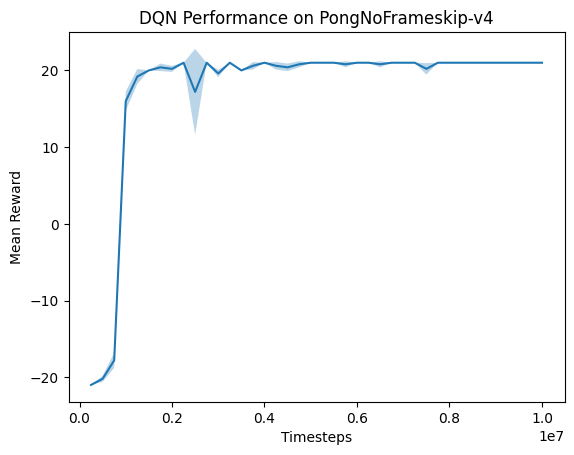

In [22]:
# Load the evaluations.npz file
data = numpy.load(os.path.join(model_folder_path, "evaluations.npz"))

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

# Plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps,
                               mean_results - std_results,
                               mean_results + std_results,
                               alpha=0.3)

matplotlib.pyplot.xlabel('Timesteps')
matplotlib.pyplot.ylabel('Mean Reward')
matplotlib.pyplot.title(f"{rl_type} Performance on {env_str}")
matplotlib.pyplot.show()